In [3]:
import pkg_resources
import pip
installedPackages = {pkg.key for pkg in pkg_resources.working_set}
required = {'nltk', 'spacy', 'textblob', 'backtrader'}
missing = required - installedPackages
if missing:
    !pip install nltk==3.4
    !pip install textblob==0.15.3
    !pip install -U SpaCy==2.2.0
    !python -m spacy download en_core_web_lg
    !pip install backtrader==1.9.74.123    

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 53.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for nltk: filename=nltk-3.4-py3-none-any.whl size=1436396 sha256=13505f24fd95c5f3906da2d701062ebb289af1fbf914c208bf451f8b70eaa7ae
  Stored in directory: /root/.cache/pip/wheels/30/cb/3e/ae17c28eb286abfcd886fdab69f9533bb060dc0a74f3b41d0d
Successfully built nltk
  Attempting uninstall: nltk
    Found existing installation: nltk 3.8.1
    Uninstalling nltk-3.8.1:
      Successfully uninstalled nltk-3.8.1
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 636.5/636.5 kB 34.3 MB/s eta 0:00:00
  Attempting uninstall: textblob
    Found existing installation: textblob 0.17.1
    Uninstalling textblob-0.17.1:
      Successfully uninstalled textblob-0.17.1
Looking in indexe

In [4]:
#carichiamo le librerie necessarie
#NLP libraries
from textblob import TextBlob
import spacy
import nltk
import warnings
from nltk.sentiment.vader import SentimentIntensityAnalyzer
nltk.download('vader_lexicon')
import csv
import pandas as pd

#Run the command python -m spacy download en_core_web_sm to download this
#https://spacy.io/models
import en_core_web_lg
nlp = en_core_web_lg.load()

#Libraries for processing the news headlines
from lxml import etree
import json
from io import StringIO
from os import listdir
from os.path import isfile, join
from pandas.tseries.offsets import BDay
from scipy.stats.mstats import winsorize
from copy import copy

# Libraries for Classification for modeling the sentiments
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Keras package for the deep learning model for the sentiment prediction. 
from keras.preprocessing.text import Tokenizer
from keras.utils import pad_sequences
#from keras_preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Flatten, LSTM, Dropout, Activation
from keras.layers import Embedding
#from keras.layers.embeddings import Embedding

# Load libraries
import statsmodels.api as sm
import seaborn as sns
import pandas as pd
import numpy as np
import datetime
from datetime import date
import matplotlib.pyplot as plt
import yfinance as yf

#Additional Libraries 
import json  
import zipfile
import os.path
import sys

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


In [5]:
#Disable the warnings
import warnings
warnings.filterwarnings('ignore')

I dati delle azioni dello S&P 500 sono stati scaricati da Yahoo Finance e messi all'interno del file .csv "Step2.2_ReturnData.csv" così dobbiamo solo caricarlo dal nostro computer e salvarlo in una variabile.

In [6]:
#carichiamo il file .csv con i dati delle azioni da Yahoo Finance
from google.colab import files
uploaded = files.upload()
df_ticker_return = pd.read_csv('Step2.2_ReturnData.csv')

Saving Step2.2_ReturnData.csv to Step2.2_ReturnData.csv


In [7]:
df_ticker_return.head(5)

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits,ticker
0,2010-01-04,26.40,26.53,26.27,26.47,123432400,0.0,0.0,AAPL
1,2010-01-05,26.54,26.66,26.37,26.51,150476200,0.0,0.0,AAPL
2,2010-01-06,26.51,26.62,26.06,26.09,138040000,0.0,0.0,AAPL
3,2010-01-07,26.19,26.22,25.85,26.04,119282800,0.0,0.0,AAPL
4,2010-01-08,26.01,26.22,25.85,26.22,111902700,0.0,0.0,AAPL


I dati delle News sono stai scaricati dal News RSS Fedd in formato json all'interno di una cartella .zip. Successivamente i tioli delle News sono stati estratti dal complesso formato di HTML tramite json parser per essere utilizzati nell'analisi. Poi i dati delle News e delle azioni sono stati combinati e messi all'interno di un DataFrame.

In [8]:
#carichiamo il file .csv con i dati delle News e delle azioni combinati
uploaded = files.upload()
data_df = pd.read_csv('Step3_NewsAndReturnData.csv', sep='|')
data_df = data_df.dropna()

Saving Step3_NewsAndReturnData.csv to Step3_NewsAndReturnData.csv


In [9]:
data_df.head(5)

,ticker,headline,date,eventRet,Close
0,AMZN,Whole Foods (WFMI) -5.2% following a downgrade...,2011-05-02,0.017650,201.19
1,NFLX,Netflix (NFLX +1.1%) shares post early gains a...,2011-05-02,-0.013003,33.88
2,MSFT,The likely winners in Microsoft's (MSFT -1.4%)...,2011-05-10,-0.019823,20.63
3,MSFT,Microsoft (MSFT -1.2%) and Skype signed their ...,2011-05-10,-0.019823,20.63
5,AMZN,Amazon.com (AMZN -1.7%) shares slip as comment...,2011-05-12,-0.006607,206.07


Ora, abbiamo preparato un DataFrame pulito con le seguenti colonne: ticker, titolo, data, rendimento dell'evento, rendimento per un determinato giornoe rendimento futuro per 10 titoli di borsa univoci con un totale di 2759 righe di dati. 

In [10]:
print(data_df.shape, data_df.ticker.unique().shape)

(2759, 5) (10,)


Per arrivare a questo punto abbiamo saltato le fasi di carimento, di preelaborazione e di combinazione dei dati delle News e delle azioni. Per la consultazione del codice usato per queste fasi si rimanda al seguente link: https://github.com/tatsath/fin-ml/blob/master/Chapter%2010%20-%20Natural%20Language%20Processing/Case%20Study%201%20-%20NLP%20and%20Sentiments%20Analysis%20based%20Trading%20Strategy/NLPandSentimentAnalysisBasedTradingStrategy.ipynb

# Modello predefinito: pacchetto TextBlob



In [11]:
text1 = "Bayer (OTCPK:BAYRY) started the week up 3.5% to €74/share in Frankfurt, touching their \
highest level in 14 months, after the U.S. government said a $25M glyphosate decision against the \
company should be reversed."

TextBlob(text1).sentiment.polarity

0.5

In [12]:
#lo applichiamo per tutte le headline del DataFrame 
data_df['sentiment_textblob'] = [TextBlob(s).sentiment.polarity for s in data_df['headline']] 

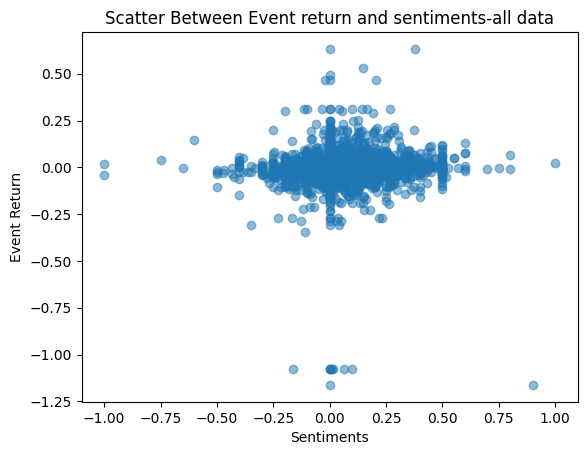

In [13]:
#analizziamo lo scatterplot dei sentimenti e dei rendimenti
plt.scatter(data_df['sentiment_textblob'],data_df['eventRet'], alpha=0.5)
plt.title('Scatter Between Event return and sentiments-all data')
plt.ylabel('Event Return')
plt.xlabel('Sentiments')
plt.show()

In [14]:
#calcola la correlazione tra i rendimenti ed i sentimenti
corrlation = data_df['eventRet'].corr(data_df['sentiment_textblob'])
print(corrlation)

0.042749340813834226


La correlazione è positiva il che significa che le news con sentimenti positivi portano a rendimenti positivi. Tuttavia, la correlazione non è molto alta.  

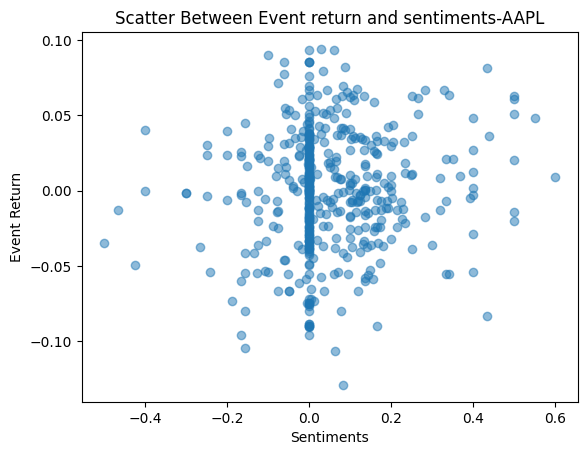

In [15]:
#scatter plot per il titolo di Apple
data_df_stock  = data_df[data_df['ticker'] == 'AAPL']
plt.scatter(data_df_stock['sentiment_textblob'],data_df_stock['eventRet'], alpha=0.5)
plt.title('Scatter Between Event return and sentiments-AAPL')
plt.ylabel('Event Return')
plt.xlabel('Sentiments')
plt.show()

Possiamo osservare che non c'è un'elevata correlazione tra sentimento e le news. Inoltre, ci sono molti sentimenti centrati a 0.

In [16]:
text = "Bayer (OTCPK:BAYRY) started the week up 3.5% to €74/share in Frankfurt, touching their highest level in 14 months, after the U.S. government said a $25M glyphosate decision against the company should be reversed."
TextBlob(text).sentiment_assessments

Sentiment(polarity=0.5, subjectivity=0.5, assessments=[(['touching'], 0.5, 0.5, None)])

Vediamo che la frase ha un sentimento positivo di 0.5 ma osservando le parole che danno origine ai sentimenti, la parola "touching" e non "high" provoca un sentimento positivo, il che non è proprio come ci si aspetterebbe.


# Apprendimento supervisionato: algoritmi di classificazione e LSTM

In [17]:
uploaded = files.upload()
sentiments_data = pd.read_csv(r'LabelledNewsData.csv',encoding = "ISO-8859-1")

Saving LabelledNewsData.csv to LabelledNewsData (1).csv


In [20]:
sentiments_data.head(5)

,datetime,headline,ticker,sentiment
0,1/16/2020 5:25,$MMM fell on hard times but could be set to re...,MMM,0
1,1/11/2020 6:43,Wolfe Research Upgrades 3M $MMM to ¡§Peer Perf...,MMM,1
2,1/9/2020 9:37,3M $MMM Upgraded to ¡§Peer Perform¡¨ by Wolfe ...,MMM,1
3,1/8/2020 17:01,$MMM #insideday follow up as it also opened up...,MMM,1
4,1/8/2020 7:44,$MMM is best #dividend #stock out there and do...,MMM,0


In [19]:
print(sentiments_data.shape[0],',', sentiments_data.ticker.unique().shape[0])

9470 , 30


In [21]:
#word-embedding
all_vectors = pd.np.array([pd.np.array([token.vector for token in nlp(s) ]).mean(axis=0)*pd.np.ones((300)) \
                           for s in sentiments_data['headline']])

In [22]:
# split out validation dataset for the end
Y= sentiments_data["sentiment"]
X = all_vectors

from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV
validation_size = 0.3
seed = 7
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=validation_size, random_state=seed)

# test options for classification
num_folds = 10
seed = 7
scoring = 'accuracy'

# spot check the algorithms
models = []
models.append(('LR', LogisticRegression()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('SVM', SVC()))
#Neural Network
models.append(('NN', MLPClassifier()))
#Ensable Models 
models.append(('RF', RandomForestClassifier()))

In [24]:
#eseguiamo tutti i modelli di classificazione
results = []
names = []
kfold_results = []
test_results = []
train_results = []
for name, model in models:
    kfold = KFold(n_splits=num_folds, random_state=seed, shuffle=True)
    cv_results = cross_val_score(model, X_train, Y_train, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    #msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    #print(msg)
   # Full Training period
    res = model.fit(X_train, Y_train)
    train_result = accuracy_score(res.predict(X_train), Y_train)
    train_results.append(train_result)
    
    # Test results
    test_result = accuracy_score(res.predict(X_test), Y_test)
    test_results.append(test_result)    
    
    msg = "%s: %f (%f) %f %f" % (name, cv_results.mean(), cv_results.std(), train_result, test_result)
    print(msg)
    print(confusion_matrix(res.predict(X_test), Y_test))
    #print(classification_report(res.predict(X_test), Y_test))

LR: 0.872982 (0.006606) 0.893951 0.870468
[[1035  169]
 [ 199 1438]]
KNN: 0.759392 (0.013987) 0.848243 0.763816
[[ 842  279]
 [ 392 1328]]
CART: 0.692715 (0.017654) 0.999698 0.689546
[[ 770  418]
 [ 464 1189]]
SVM: 0.831200 (0.015621) 0.862875 0.833861
[[ 955  193]
 [ 279 1414]]
NN: 0.898780 (0.014649) 0.999095 0.908131
[[1064   91]
 [ 170 1516]]
RF: 0.789109 (0.011957) 0.999698 0.789511
[[ 829  193]
 [ 405 1414]]


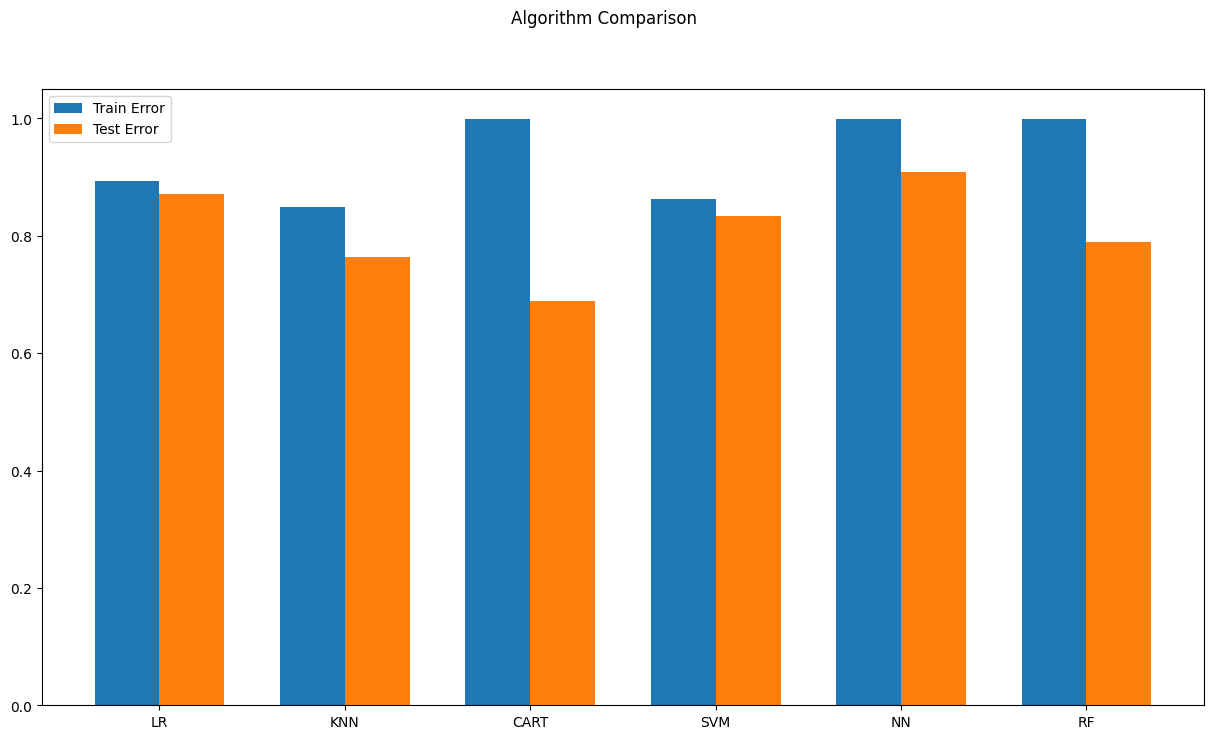

In [25]:
#confrontiamo gli algoritmi
from matplotlib import pyplot
fig = pyplot.figure()
ind = np.arange(len(names))  # the x locations for the groups
width = 0.35  # the width of the bars
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
pyplot.bar(ind - width/2, train_results,  width=width, label='Train Error')
pyplot.bar(ind + width/2, test_results, width=width, label='Test Error')
fig.set_size_inches(15,8)
pyplot.legend()
ax.set_xticks(ind)
ax.set_xticklabels(names)
pyplot.show()

# LSTM
Per poter inserire i dati nel nostro modello LSTM, tutti i documenti di input devono avere la stessa lunghezza. Usiamo la funzione tokenizer di Keras per tokenizzare le stringhe e quindi usiamo texts_to_sequences per creare sequenze di parole. Maggiori dettagli possono essere trovati sul sito Web di Keras. Limiteremo la lunghezza massima della recensione a max_words troncando le recensioni più lunghe e riempiendo le recensioni più brevi con un valore nullo (0). Possiamo farlo usando la funzione pad_sequences. Il terzo parametro è input_length (impostato su 50), che è la lunghezza di ciascuna sequenza di commenti.

In [26]:
### Create sequence
vocabulary_size = 20000
tokenizer = Tokenizer(num_words= vocabulary_size)
tokenizer.fit_on_texts(sentiments_data['headline'])
sequences = tokenizer.texts_to_sequences(sentiments_data['headline'])
X_LSTM = pad_sequences(sequences, maxlen=50)

In [27]:
#dividiamo i dati in training e test set
Y_LSTM = sentiments_data["sentiment"]
X_train_LSTM, X_test_LSTM, Y_train_LSTM, Y_test_LSTM = train_test_split(X_LSTM, \
                       Y_LSTM, test_size=validation_size, random_state=seed)

Nel seguente frammento di codice, utilizziamo la libreria Keras per creare un classificatore di rete neurale artificiale basato su un modello LSTM sottostante. La rete inizia con un livello di incorporamento . Questo livello consente al sistema di espandere ogni token in un vettore più grande, consentendo alla rete di rappresentare una parola in modo significativo. Il layer prende 20.000 come primo argomento (cioè la dimensione del nostro vocabolario) e 300 come secondo parametro di input (cioè la dimensione dell'incorporamento). Infine, dato che si tratta di un problema di classificazione e l'output deve essere etichettato come zero o uno, la funzione KerasClassifier viene utilizzata come wrapper sul modello LSTM per produrre un output binario (zero o uno).

In [28]:
from keras.wrappers.scikit_learn import KerasClassifier
def create_model(input_length=50):
    model = Sequential()
    model.add(Embedding(20000, 300, input_length=50))
    model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])    
    return model    
model_LSTM = KerasClassifier(build_fn=create_model, epochs=3, verbose=1, validation_split=0.4)
model_LSTM.fit(X_train_LSTM, Y_train_LSTM)

Epoch 1/3
125/125 [==============================] - 29s 184ms/step - loss: 0.3989 - accuracy: 0.8061 - val_loss: 0.1521 - val_accuracy: 0.9434
Epoch 2/3
125/125 [==============================] - 22s 172ms/step - loss: 0.0608 - accuracy: 0.9801 - val_loss: 0.0841 - val_accuracy: 0.9672
Epoch 3/3
125/125 [==============================] - 23s 182ms/step - loss: 0.0144 - accuracy: 0.9967 - val_loss: 0.0857 - val_accuracy: 0.9661


In [29]:
train_result_LSTM = accuracy_score(model_LSTM.predict(X_train_LSTM), Y_train_LSTM)
# Test results
test_result_LSTM = accuracy_score(model_LSTM.predict(X_test_LSTM), Y_test_LSTM)

89/89 [==============================] - 2s 17ms/step


In [30]:
print(train_result_LSTM,test_result_LSTM)

0.9858198823351938 0.9655051038366772


In [31]:
train_results.append(train_result_LSTM)
test_results.append(test_result_LSTM)

In [32]:
names.append("LSTM")

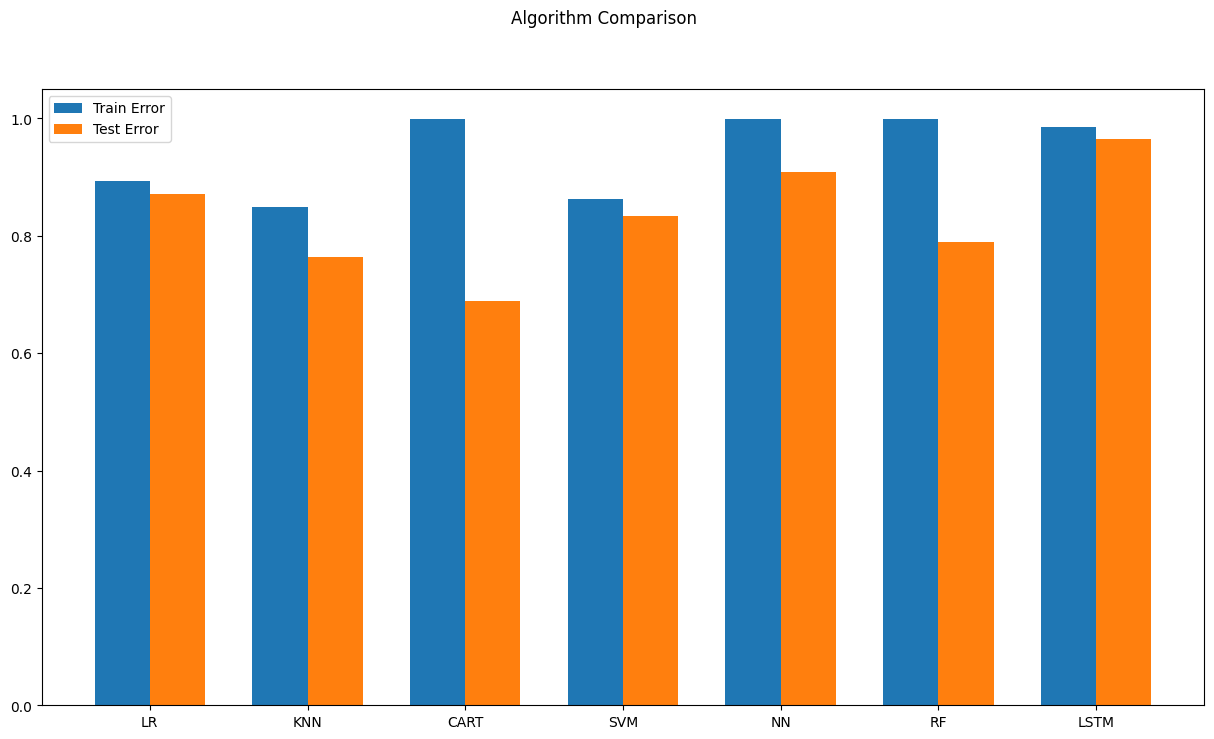

In [33]:
# compare algorithms
from matplotlib import pyplot
fig = pyplot.figure()
ind = np.arange(len(names))  # the x locations for the groups
width = 0.35  # the width of the bars
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
pyplot.bar(ind - width/2, train_results,  width=width, label='Train Error')
pyplot.bar(ind + width/2, test_results, width=width, label='Test Error')
fig.set_size_inches(15,8)
pyplot.legend()
ax.set_xticks(ind)
ax.set_xticklabels(names)
pyplot.show()

In [34]:
#usiamo il modello LSTM per calcolare i sentimenti sui dati precedenti
sequences_LSTM = tokenizer.texts_to_sequences(data_df['headline'])
X_LSTM = pad_sequences(sequences_LSTM, maxlen=50)

In [35]:
Y_LSTM = model_LSTM.predict(X_LSTM)

87/87 [==============================] - 2s 27ms/step


In [36]:
data_df['sentiment_LSTM'] = Y_LSTM 

In [37]:
corrlation = data_df['eventRet'].corr(data_df['sentiment_LSTM'])
print(corrlation)

0.10035895038813851


In [39]:
data_df.head(5)

,ticker,headline,date,eventRet,Close,sentiment_textblob,sentiment_LSTM
0,AMZN,Whole Foods (WFMI) -5.2% following a downgrade...,2011-05-02,0.017650,201.19,0.262500,0
1,NFLX,Netflix (NFLX +1.1%) shares post early gains a...,2011-05-02,-0.013003,33.88,-0.043750,1
2,MSFT,The likely winners in Microsoft's (MSFT -1.4%)...,2011-05-10,-0.019823,20.63,0.166667,1
3,MSFT,Microsoft (MSFT -1.2%) and Skype signed their ...,2011-05-10,-0.019823,20.63,-0.030556,1
5,AMZN,Amazon.com (AMZN -1.7%) shares slip as comment...,2011-05-12,-0.006607,206.07,0.000000,0


# Apprendimento non supervisionato: modello basato su lessico finanziario



In [42]:
# stock market lexicon
uploaded = files.upload()
sia = SentimentIntensityAnalyzer()
stock_lex = pd.read_csv('LexiconData.csv')
stock_lex['sentiment'] = (stock_lex['Aff_Score'] + stock_lex['Neg_Score'])/2
stock_lex = dict(zip(stock_lex.Item, stock_lex.sentiment))
stock_lex = {k:v for k,v in stock_lex.items() if len(k.split(' '))==1}
stock_lex_scaled = {}
for k, v in stock_lex.items():
    if v > 0:
        stock_lex_scaled[k] = v / max(stock_lex.values()) * 4
    else:
        stock_lex_scaled[k] = v / min(stock_lex.values()) * -4

final_lex = {}
final_lex.update(stock_lex_scaled)
final_lex.update(sia.lexicon)
sia.lexicon = final_lex

Saving LexiconData.csv to LexiconData (1).csv


In [43]:
#estraiamo il punteggio del sentimento da una frase
text = "AAPL is trading higher after reporting its October sales rose 12.6% M/M. It has seen a 20%+ jump in orders"
sia.polarity_scores(text)['compound']

0.4535

In [44]:
#ora estraiamo il sentimento per l'intero dataset
vader_sentiments = pd.np.array([sia.polarity_scores(s)['compound'] for s in data_df['headline']])
vader_sentiments.shape

(2759,)

In [45]:
data_df['sentiment_lex'] = vader_sentiments

In [46]:
corrlation = data_df['eventRet'].corr(data_df['sentiment_lex'])
print(corrlation)

0.10477850058004673


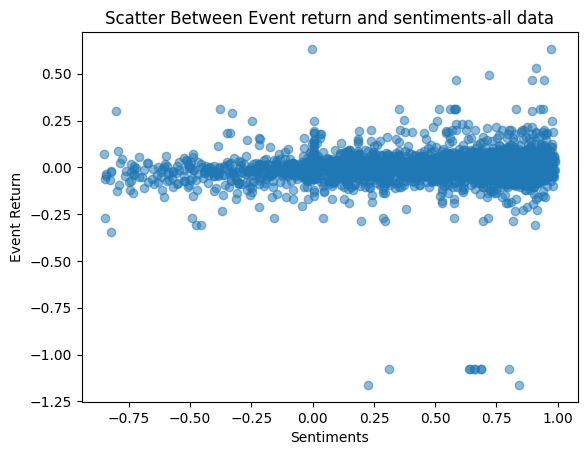

In [47]:
plt.scatter(data_df['sentiment_lex'],data_df['eventRet'], alpha=0.5)
plt.title('Scatter Between Event return and sentiments-all data')
plt.ylabel('Event Return')
plt.xlabel('Sentiments')
plt.show()

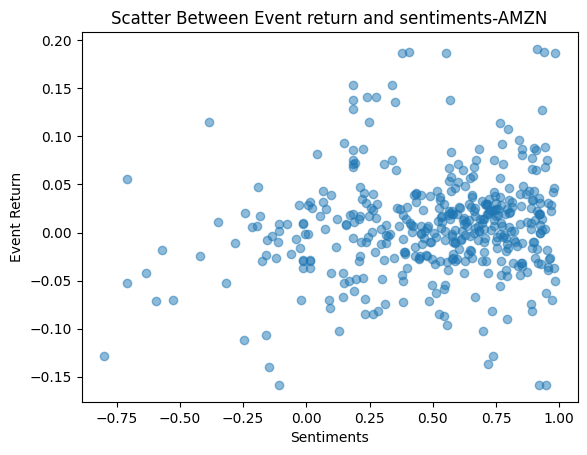

In [48]:
data_df_stock  = data_df[data_df['ticker'] == 'AMZN']
plt.scatter(data_df_stock['sentiment_lex'],data_df_stock['eventRet'], alpha=0.5)
plt.title('Scatter Between Event return and sentiments-AMZN')
plt.ylabel('Event Return')
plt.xlabel('Sentiments')
plt.show()

# Analisi esplorativa dei dati e confronto



In [50]:
uploaded = files.upload()
tickers = ['AAPL','MSFT','AMZN','GOOG','FB','WMT','JPM','TSLA','NFLX','ADBE']
data_df = pd.read_csv(r'Step4_DataWithSentimentsResults.csv', sep='|')
data_df = data_df[data_df['ticker'].isin(tickers)]

Saving Step4_DataWithSentimentsResults.csv to Step4_DataWithSentimentsResults (1).csv


In [51]:
data_new_df_stock=data_df[data_df['ticker']== 'NFLX'][['ticker','headline','sentiment_textblob','sentiment_LSTM','sentiment_lex']]
from pandas import option_context

with option_context('display.max_colwidth', 400):
    display(data_new_df_stock.head(1))

,ticker,headline,sentiment_textblob,sentiment_LSTM,sentiment_lex
1,NFLX,"Netflix (NFLX +1.1%) shares post early gains after Citigroup ups its rating to Buy and lifts its price target to $300 from $245. U.S. revenue growth is sustainable, Citi says, ""with a path to 50M subscribers by 2013,"" adding that NFLX has little competition in price, selection and convenience; mass market adoption of tablets will help, and the mass-market adoption phase is still to come.",-0.04375,1,0.8575


<Axes: title={'center': 'Correlation Matrix'}>

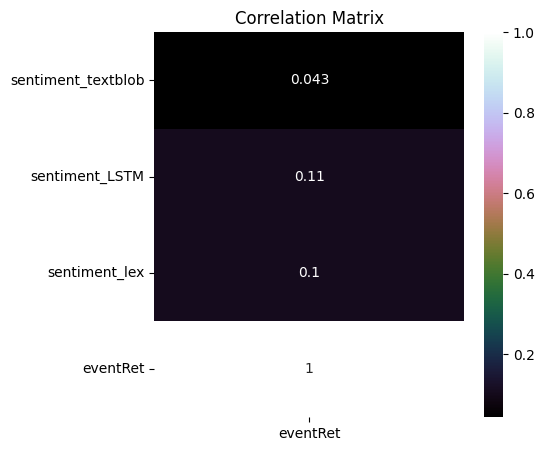

In [52]:
correlation = data_df[['sentiment_textblob','sentiment_LSTM','sentiment_lex','eventRet']].dropna(axis=0).corr()

plt.figure(figsize=(5,5))
plt.title('Correlation Matrix')
sns.heatmap(correlation[['eventRet']], vmax=1, annot=True,cmap='cubehelix')

In [53]:
corr_data = []
for ticker in data_df['ticker'].unique():
    data_new_df_stock=data_df[data_df['ticker']==ticker]
    #Only look for the stocks with sufficient data
    if data_new_df_stock.shape[0] > 40 : 
        corr_textblob= data_new_df_stock['eventRet'].corr(data_new_df_stock['sentiment_textblob'])    
        corr_LSTM = data_new_df_stock['eventRet'].corr(data_new_df_stock['sentiment_LSTM'])
        corr_lex = data_new_df_stock['eventRet'].corr(data_new_df_stock['sentiment_lex'])
        corr_data.append([ticker,corr_textblob, corr_LSTM, corr_lex])
        #print(ticker,corr_vader, corr_LSTM, corr_textblob)
    else:
        continue

In [56]:
corr_df = pd.DataFrame(corr_data, columns =  ['ticker','corr_textblob','corr_LSTM','corr_lex'])  
corr_df=corr_df.set_index('ticker')
corr_df.head(5)

,corr_textblob,corr_LSTM,corr_lex
ticker,,,
AMZN,0.019830,0.111176,0.138296
NFLX,0.092630,0.110750,0.218663
MSFT,-0.025318,0.148976,0.034494
GOOG,0.044213,0.163755,0.196258
JPM,-0.160327,0.170022,0.025343


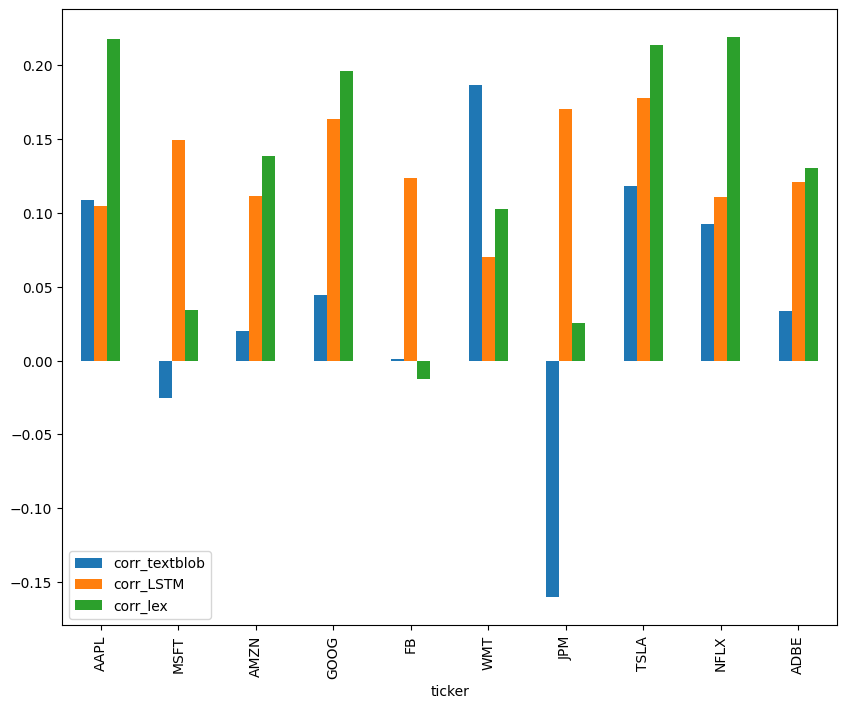

In [55]:
#corr_df.to_csv("correlation.csv")     
#tickers = ['AAPL','MSFT','AMZN','GOOG','BABA','FB','WMT','V','JPM','TSLA']
corr_df.loc[tickers].plot.bar(figsize = (10,8))
plt.show()

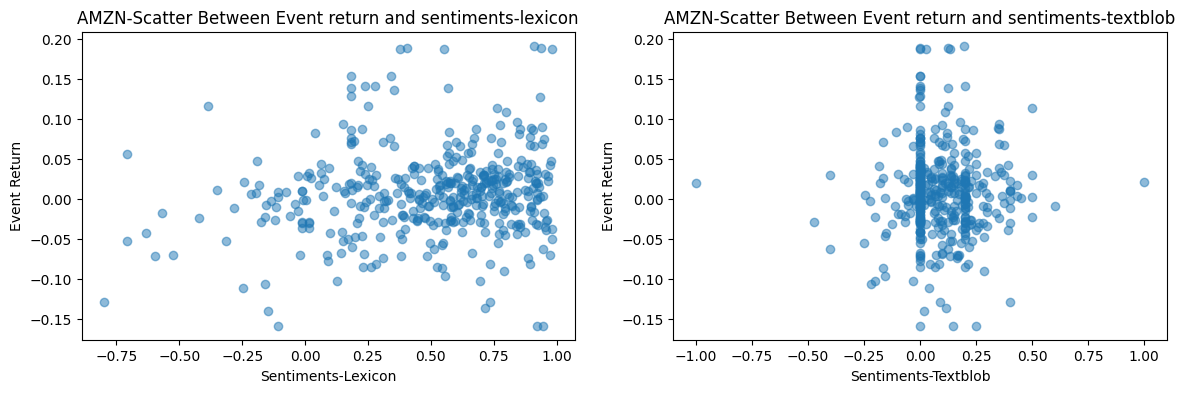

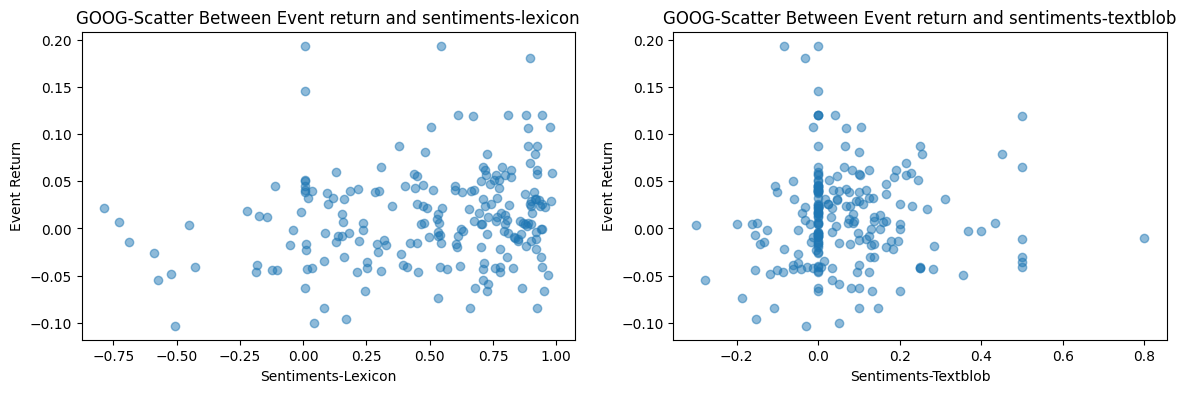

In [57]:
#tickers = corr_df.nlargest(5,'corr_lex').index
for ticker in tickers[2:4]:
    data_df_stock  = data_df[data_df['ticker'] == ticker]
    fig = plt.figure(figsize=(14, 4), constrained_layout=False)

    plt.subplot(1, 2, 1)
    plt.scatter(data_df_stock['sentiment_lex'],data_df_stock['eventRet'], alpha=0.5)
    plt.title(ticker + '-Scatter Between Event return and sentiments-lexicon')
    plt.ylabel('Event Return')
    plt.xlabel('Sentiments-Lexicon')

    
    plt.subplot(1, 2, 2)
    plt.scatter(data_df_stock['sentiment_textblob'],data_df_stock['eventRet'], alpha=0.5)
    plt.title(ticker + '-Scatter Between Event return and sentiments-textblob')
    plt.ylabel('Event Return')
    plt.xlabel('Sentiments-Textblob')
    plt.show()